# Project 2:
## Authors: Frederick Nilsen, Mia Rødde, Sara Abnar

### Warnings

* Ikke endre uten at de andre vet det
* **Alltid** gå på Kernel -> Restart & Clear Output
* Ikke skriv utenfor cellene og sånn

## Implementation of set 1 - points in 2D

In [14]:
## IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from loader import get_dataset
import plotting
from spirals import get_data_spiral_2d

In [20]:
## GLOBAL CONSTS AND DEFINITIONS

sigma = lambda x : np.tanh(x)         # Activation function
eta = lambda x : 0.5*(1+np.tanh(x/2)) # Scalar function     
eta_ddx = lambda x :  0.25*(1-np.tanh(x/2)*np.tanh(x/2)) # Derivative of eta
sigma_ddx = lambda x: 1-(np.tanh(x))**2 # Derivative of sigma


K = 10 # +1 gives number of layers, arbitrary number
d = 2 # Ehh
tau = 0.1 # learning parameter [0.01,0.1]
Y0, C = get_data_spiral_2d(200) #Default n=200
I = Y0.shape[1]

np.random.seed(0)
W = np.random.randn(K,d,d)
np.random.seed(0)
b = np.random.randn(K,d,1)     #startverdier
np.random.seed(0)
mu = np.random.randn()
np.random.seed(0)
w = np.random.randn(d,1)
h = 0.1

Ulst = [W, b, w, mu]

In [21]:
## INITIALISATION CELL
def getColorFromLabel(C):
    colorLst = []
    for el in C:
        if el:
            colorLst.append('r')
        else:
            colorLst.append('b')
    return colorLst
C_colors = getColorFromLabel(C)


#optimert funksjon
def YK(W, b, Ystart=Y0):
    #tom Y-matrise, 3-dimensjonalt numpy-array
    Ym = np.zeros((K+1,d,I))
    Ym[0,:,:] = np.copy(Ystart)
    k=0
    while k < K:
        Ym[k+1] = Ym[k] + h*sigma(W[k]@Ym[k] + b[k])
        k+=1
    return Ym

#Finner P_K
def getGradients(K, W, b, w, mu, c=C, Ystart=Y0):
    Y_all = YK(W,b, Ystart)
    lastY = Y_all[-1,:,:]
    P = np.zeros((Y_all.shape)) # init matrix
    P[K,:,:] = w@np.transpose((Zf(w,mu, lastY)-c)*eta_ddx(np.transpose(lastY)@w+mu))  #(7)
    
    dJdMU = eta_ddx(np.transpose(np.transpose(lastY)@w+mu))@(Zf(w,mu, lastY)-c)   #(5), kunne også brukt '.T' for transpose
    dJdw = lastY@((Zf(w,mu, lastY)-c)*eta_ddx(np.transpose(lastY)@w+mu))              #(6)
    for k in range(K,0,-1):
        P[k-1,:,:] = P[k,:,:]+h*np.transpose(W[k-1,:,:])@(sigma_ddx(W[k-1,:,:]@Y_all[k-1,:,:]+b[k-1,:,:])*P[k,:,:])  #(8) 
    dJdWk = np.zeros((K,d,d))
    dJdBk = np.zeros((K,d,1))
    
    for k in range(0,K):
        dJdWk[k] = h*(P[k+1]*sigma_ddx(W[k,:,:]@Y_all[k,:,:]+b[k,:,:]))@np.transpose(Y_all[k,:,:])  #(9)
        dJdBk[k] = h*(P[k+1]*sigma_ddx(W[k,:,:]@Y_all[k,:,:]+b[k,:,:]))@np.ones((I,1)) #One not needed?#(10)
    return dJdWk, dJdBk, dJdw, dJdMU


#Adam descent algorithm
def AdamAlg(Ulst, m, v, c=C, Ystart=Y0):
    beta1 = 0.9
    beta2 = 0.999
    alpha = 0.01
    epsilon = 1e-8
    gradLst = [x for x in getGradients(K, W, b, w, mu, c, Ystart)]
    for i in range(len(gradLst)):
        g = gradLst[i]
        m[i] = beta1*m[i]+(1-beta1)*g
        v[i] = beta2*v[i]+(1-beta2)*(g*g)
        mhat = m[i]/(1-beta1**(counter))
        vhat = v[i]/(1-beta2**(counter))
        Ulst[i] -= alpha*mhat/(np.sqrt(vhat)+epsilon)
    return Ulst, m, v

In [22]:
#Lager siste Y_k = Y_K
YK_list = YK(W,b)
lastY = YK_list[-1,:,:]

Zf = lambda w,mu,finalY=lastY : eta(np.transpose(finalY)@w +mu)
Z=Zf(w,mu)
Jf = lambda Z=Zf(w,mu), ce=C : 1/2*np.linalg.norm(Z-ce)**2 #Cost function
J = Jf()

In [23]:
for i in range(1,5000):   #Skal være 40001
    #print(YK_list)
    dJdWk, dJdBk, dJdw, dJdMU = getGradients(K, W, b, w, mu)
    W-=tau*dJdWk
    b-=tau*dJdBk
    w-=tau*dJdw
    mu-=tau*dJdMU

0.042406822374293295


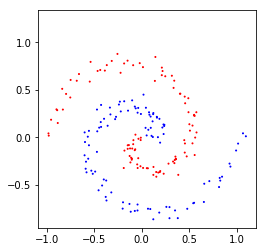

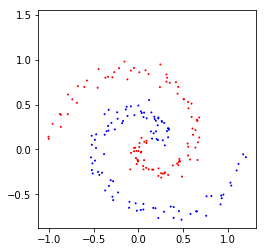

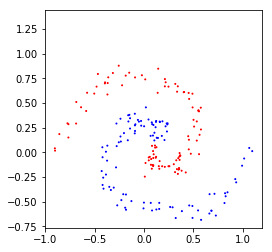

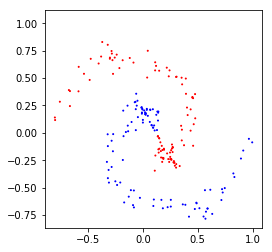

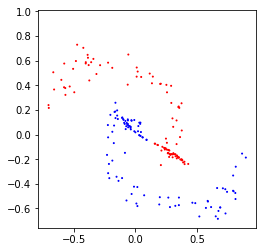

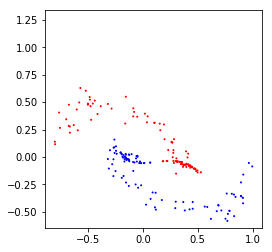

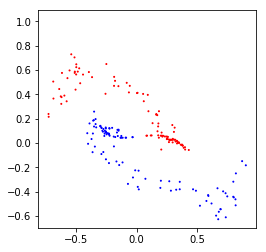

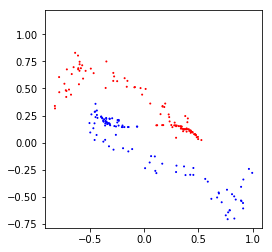

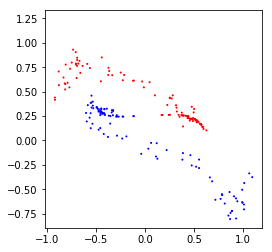

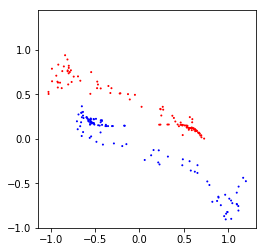

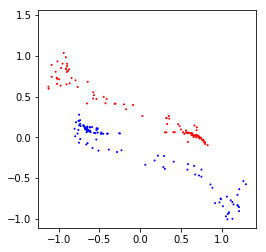

In [24]:
from plotting import *

testY, testC = get_data_spiral_2d(200)
trainedY = YK(W, b, testY)
print(Jf(Zf(w,mu, trainedY[-1,:,:]), testC))

plot_progression(trainedY, getColorFromLabel(testC))

#tau = 0.1: 8.665036835075993
#tau = 0.08: 11.925073101031389

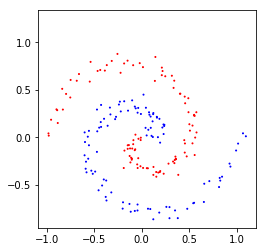

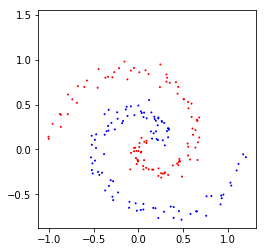

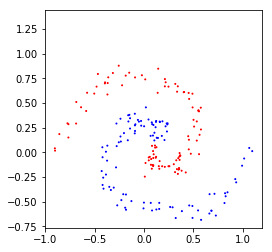

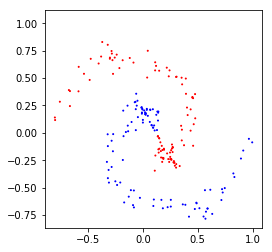

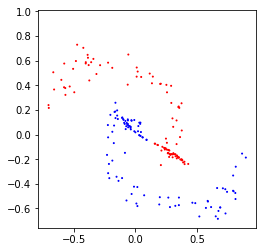

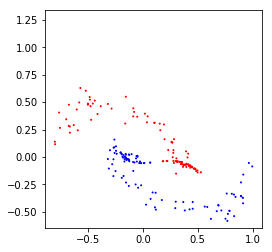

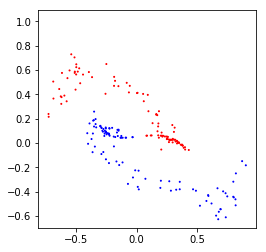

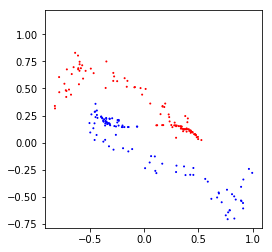

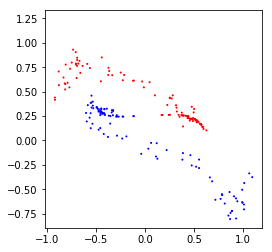

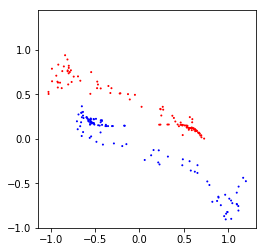

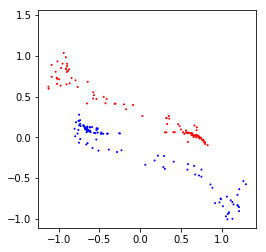

In [25]:
from plotting import *

def checkResults(n=I):
    testY, testC = get_data_spiral_2d(n)
    trainedY = YK(W, b, testY)
    lastY = trainedY[K,:,:]
    trainedZ = Zf(w,mu,lastY)

    J_new=Jf(trainedZ,testC)
    numTrue=0
    numJTrue = 0
    print(J_new)
    for i in range(n):
        if testC[i][0]:
            numTrue+=1
        if trainedZ[i][0] >= 0.75:
            print(trainedZ[i][0])
            numJTrue+=1
    print("Antall true:", numTrue)
    print("Ifølge J:", numJTrue)
    print("Andel riktige, ", numJTrue/numTrue*100, "%", sep="")
    
testY, testC = get_data_spiral_2d(200)
trainedY = YK(W, b, testY)
lastY = trainedY[K,:,:]
trainedZ = Zf(w,mu,lastY)

trainedY = YK(W, b, testY)
plot_progression(trainedY, getColorFromLabel(testC))

In [26]:
checkResults()

0.042406822374293295
0.9952227456061693
0.9440919131431982
0.9873261156568257
0.9948828580763189
0.9978031076238858
0.9999794238246251
0.9926425882272019
0.9943218369851464
0.97542799961322
0.9975068131928175
0.9904336165846928
0.992937462603265
0.9927828402701651
0.9952642147032658
0.9995658369515348
0.9927458572029604
0.9768627844479176
0.9999993123725672
0.9902568420245916
0.9931550763832222
0.9875609287437631
0.9926739201487891
0.9996193162828806
0.9055767232422047
0.9901109512439887
0.9837757032132921
0.9769680611830054
0.9946171093700358
0.9989282643580911
0.9975830673729278
0.9883322008372377
0.9999177032570306
0.999123875963511
0.9996147411269827
0.9959023297165512
0.9996264297670622
0.9999306346903094
0.992254863981779
0.9932072856174916
0.9946770994694272
0.9954553732731491
0.9416426360443201
0.9990315378661114
0.9904445835833056
0.9934005012720277
0.9995210749264236
0.9886392455933918
0.9975533945758618
0.9732353856132767
0.9976619286190178
0.9981350062602554
0.9948297620365

In [7]:
#INITIALISING LIST, PART 2
K = 10 #number of layers, arbitrary number
Y0pic, C_pic = get_dataset()
d = Y0pic.shape[0]
I = Y0pic.shape[1]

np.random.seed(0)
W = np.random.randn(K,d,d)
np.random.seed(0)
b = np.random.randn(K,d,1)     #startverdier
np.random.seed(0)
mu = np.random.randn()
np.random.seed(0)
w = np.random.randn(d,1)
h = 0.1

Ulst = np.array([W, b, w, mu])

In [8]:
#algorithm for pictures
counter = 1

#initializing list
m = [0 for x in range(len(Ulst))]
v = [0 for x in range(len(Ulst))]

#for AdamAlg
for i in range(1,11):   #Skal være 40001
    Ulst, m, v = AdamAlg(Ulst, m, v, C_pic, Y0pic)
    print(counter)
    counter +=1 
    
W, b, w, mu = Ulst
testpic, testCp = get_dataset()
trainedPic = YK(W, b, testpic)
lastY = trainedPic[-1,:,:]
print(Jf(Zf(w, mu, lastY), testCp))
#koden går mye raskere men J er jo alt for høy: 2968.0000000000005

1
2
3
4
5
6
7
8
9
10
2968.0000000000005


In [12]:
def checkResults(n=I):
    trainedZ = Zf(w,mu,lastY)
    J_new=Jf(trainedZ,testCp)
    numTrue=0
    numJTrue = 0
    print(J_new)
    for i in range(n):
        if testCp[i][0]:
            #print(testCp[i][0])
            numTrue+=1
        if trainedZ[i][0] >= 0.75:
            print(trainedZ[i][0])
            numJTrue+=1
    print("Antall true:", numTrue)
    print("Ifølge J:", numJTrue)
    print("Andel riktige, ", numJTrue/numTrue*100, "%", sep="")

checkResults()

2968.0000000000005
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Antall true: 5958
Ifølge J: 50
Andel riktige, 0.8392077878482713%
